In [2]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


## Предбработка текста

In [11]:
tokenizer = WordPunctTokenizer() # объект токенизатора, который разбивает текст на слова и пунктуацию
 
def tokenize(x):
  '''
  x.lower() приводит весь текст к нижнему регистру, после чего tokenizer токенизирует текст
  разделяя его на отдельные слова и символы пунктуации, после join объединяет токенизированные 
  слова и символы с пробелами между ними
  '''
  return ' '.join(tokenizer.tokenize(x.lower()))

In [12]:
with open('train.en', 'w', encoding='utf-8') as f_src,  open('train.ru', 'w', encoding='utf-8') as f_dst:
  for line in open('data.txt', encoding='utf-8'): # читаем каждую строку из data.txt
    src_line, dst_line = line.strip().split('\t') # разделяем по табуляции на английский и русский тексты
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')

In [13]:
bpe = {} # словарь для хранения BPE
for lang in ['en', 'ru']: # сначала делаем для английского языка, а потом для русского
    # обучаем правила bpe на тексте (num_symbols - кол-во BPE пар, которые нужно создать)
    learn_bpe(open('./train.' + lang, encoding='utf-8'), open('bpe_rules.' + lang, 'w', encoding='utf-8'), num_symbols=8000) 
    bpe[lang] = BPE(open('./bpe_rules.' + lang)) # объект BPE, загружающий обученные правила из файла 

    with open('train.bpe.' + lang, 'w', encoding='utf-8') as f_out:
        for line in open('train.' + lang, encoding='utf-8'):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n') # применяем правила BPE к строке и записываем её в train.bpe

100%|██████████| 8000/8000 [00:05<00:00, 1558.46it/s]


Мы составили пары символов, которые записали в файл bpe_rules в виде (х х), после чего применили их, заменяя с использованием "@@"

In [14]:
data_inp = np.array(open('./train.bpe.ru', encoding='utf-8').read().split('\n')) # массив списка строк
data_out = np.array(open('./train.bpe.en', encoding='utf-8').read().split('\n'))

'''
Разделяем данные на обучающую и тестовую выборку, где 
data_inp - входные данные на русском языке для перевода
data_opt - выходные данные на английском
'''
train_inp, test_inp, train_out, test_out = train_test_split( 
    data_inp, 
    data_out, 
    test_size=3000,
    random_state=2023,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: э@@ т@@ о@@ т о@@ т@@ е@@ л@@ ь н@@ а@@ х@@ о@@ д@@ и@@ т@@ с@@ я в ц@@ е@@ н@@ т@@ р@@ е п@@ а@@ р@@ и@@ ж@@ а , в 2 м@@ и@@ н@@ у@@ т@@ а@@ х о@@ т п@@ л@@ о@@ щ@@ а@@ д@@ и р@@ е@@ с@@ п@@ у@@ б@@ л@@ и@@ к@@ и и с@@ т@@ а@@ н@@ ц@@ и@@ и м@@ е@@ т@@ р@@ о с 5 л@@ и@@ н@@ и@@ я@@ м@@ и м@@ е@@ т@@ р@@ о и 4 а@@ в@@ т@@ о@@ б@@ у@@ с@@ н@@ ы@@ м@@ и м@@ а@@ р@@ ш@@ р@@ у@@ т@@ а@@ м@@ и .
out: this hotel is located in the centre of paris , 2 minutes from place de la r@@ é@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: н@@ а п@@ о@@ л@@ н@@ о@@ с@@ т@@ ь@@ ю о@@ б@@ о@@ р@@ у@@ д@@ о@@ в@@ а@@ н@@ н@@ о@@ й м@@ и@@ н@@ и - к@@ у@@ х@@ н@@ е м@@ о@@ ж@@ н@@ о с@@ а@@ м@@ о@@ с@@ т@@ о@@ я@@ т@@ е@@ л@@ ь@@ н@@ о г@@ о@@ т@@ о@@ в@@ и@@ т@@ ь .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: н@@ о@@ м@@ е@@ р@@ а н@@ а@@ х@@ о@@ д@@ я@@ т@@ с@@ я п@@ о@@ д к@@ р@@ ы@@ ш@@ е@@ й и@@ л@@ и н@@ а н@@

In [15]:
from vocab import Vocab 
inp_voc = Vocab.from_lines(train_inp) # создаём объект Vocab из русского текста
out_voc = Vocab.from_lines(train_out) # создаём объект Vocab из англ текста 
batch_lines = sorted(train_inp, key=len)[5:10] # сортируем строки русского текста по длине, и выбираем только строки с 5 по 10
batch_ids = inp_voc.to_matrix(batch_lines) # преобразуем эти строки в матрицу индексов 
batch_lines_restored = inp_voc.to_lines(batch_ids) # преобразуем матрицу обратно в строки 

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['о@@ т@@ к@@ р@@ ы@@ т б@@ а@@ р .', 'д@@ о ш@@ у@@ о@@ л@@ я - 27 к@@ м .', 'д@@ о т@@ у@@ а@@ п@@ с@@ е 19 к@@ м .', 'д@@ о л@@ у@@ в@@ р@@ а — 1 , 8 к@@ м .', 'д@@ о р@@ а@@ в@@ е@@ н@@ н@@ ы 29 к@@ м .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 1627, 1635, 1619, 1631, 1653, 1634, 1601, 1599, 1630,   29,    1,
            1,    1,    1,    1],
        [   0, 1607, 1626, 1647, 1637, 1627, 1621, 1660,   27,   69, 1619, 1622,
           29,    1,    1,    1],
        [   0, 1607, 1626, 1635, 1637, 1599, 1629, 1633, 1608,   55, 1619, 1622,
           29,    1,    1,    1],
        [   0, 1607, 1626, 1621, 1637, 1603, 1631, 1598, 1666,   37,   25,  135,
         1619, 1622,   29,    1],
        [   0, 1607, 1626, 1631, 1599, 1603, 1609, 1625, 1625, 1652,   71, 1619,
         1622,   29,    1,    1]])

back to words
['о@@ т@@ к@@ р@@ ы@@ т б@@ а@@ р .', 'д@@ о ш@@ у@@ о@@ л@@ я - 27 к@@ м .', 'д@@ о т@@ у@@ а@@ п@@ с@@ е 19 к@@ м .', 'д@@ о л@@ у@@ в@@ р@@ а — 1 , 8 к@@ м .

### Распределения длин исходных текстов и переводов

(array([5.6300e+02, 8.8530e+03, 1.1836e+04, 1.1081e+04, 6.2210e+03,
        3.9950e+03, 2.4600e+03, 1.0420e+03, 4.8600e+02, 2.3600e+02,
        1.3100e+02, 5.5000e+01, 1.5000e+01, 1.1000e+01, 6.0000e+00,
        2.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  0. ,   5.3,  10.6,  15.9,  21.2,  26.5,  31.8,  37.1,  42.4,
         47.7,  53. ,  58.3,  63.6,  68.9,  74.2,  79.5,  84.8,  90.1,
         95.4, 100.7, 106. ]),
 <BarContainer object of 20 artists>)

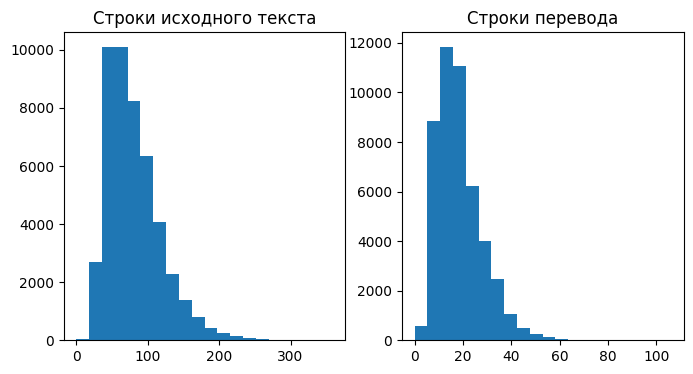

In [7]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("Строки исходного текста")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20) # распределение количества строк

plt.subplot(1, 2, 2)
plt.title("Строки перевода")
plt.hist(list(map(len, map(str.split, train_out))), bins=20)

По данному графику видно, что исходный текст имеет более широкое распределение длины строк, где наиболее частая длина строк лежит в диапазоне примерно от 10 до 100 символов. Перевод имеет аналогичное распределение, но с меньшим разбросом длин. Можно сделать вывод, что и там и там большинство строк содержит относительно мало символов

### Loss

Категориальная кросс-энтропия - это метрика, используемая в машинном обучении для оценки точности модели, когда нужно предсказать несколько классов (категорий). Эта метрика сравнивает предсказанные вероятности для каждого класса с фактическими значениями и вычисляет, насколько они отличаются друг от друга. Чем меньше значение категориальной кросс-энтропии, тем лучше модель справляется с задачей классификации.

In [16]:
def compute_loss(model, inp, out, **flags):
    """
    Вычислите потери (скаляр float32), как в формуле выше.
    :param inp: матрица входных токенов, int32[пакет, время]
    :param out: матрица ссылочных токенов, int32[пакет, время]

    Чтобы пройти тесты, ваша функция должна
    * включать потери на первом EOS, но не на последующих
    * разделить сумму потерь на сумму входных длин (используйте voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len] создает маску, которая указывает, какие токены должны учитываться при расчете потерь
    # Важно, чтобы потери включали первый токен EOS, но игнорировали последующие
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32) # преобразуем целевые токены в one-hot вектора, где длина каждого вектора = размеру словаря model.out_voc

    logits_seq = model(inp, out) # модель на основе inp и out возвращает последовательность логитов, предсказанных для каждого шага
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1) # вычисляем логарифм вероятностей для всех токенов, применяя log_softmax к логитам, вычесленным моделью
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) 
    """ 
    Умножение логарифмированных вероятностей на one-hot векторы целей позволяет выбрать логарифм вероятности только для актуальных токенов. Суммирование по последнему измерению оставляет одно значение на каждый шаг в каждом примере батча.
    
    -logp_out[mask]: Использует ранее созданную маску для выбора значений логарифма вероятностей, которые должны учитываться при расчете потерь. Знак минус необходим, так как потери - это отрицательный логарифм вероятности.
    .mean(): Среднее значение по всем выбранным потерям дает итоговую величину потерь для текущего батча.
    """
    return -logp_out[mask].mean()

### Оценка качества: BLEU


BLEU (Bilingual Evaluation Understudy) - это метрика, используемая для оценки качества машинного перевода. Она оценивает степень соответствия машинного перевода эталонному (человеческому) переводу путем сравнения пересечения n-грамм в предложениях машинного и эталонного переводов. Значение BLEU на валидационном наборе данных дает представление о том, насколько хорошо модель переводит текст на данных, которые она не видела в процессе обучения. Чем ближе значение BLEU к 1, тем лучше качество перевода с точки зрения этой метрики.

In [17]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu

def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]

        smoothie = SmoothingFunction().method1  # Использование стандартного метода сглаживания из nltk
        return corpus_bleu(
            [[ref.split()] for ref in actual], 
            [trans.split() for trans in translations],
            smoothing_function=smoothie
        ) * 100

### Функция для обучения модели

Прежде чем перейти к выполнению заданий, вынесим обучение модели в отдельную функцию

In [1]:
def model_training(model):
    metrics = {'train_loss': [], 'dev_bleu': [] } # список со значениями потерь на обучающей выборке и BLEU-оценка 
    device = 'cuda' if torch.cuda.is_available() else 'cpu' # в зависимости от доступности CUDA определяется, модель будет обучаться либо на GPU('cuda') либо на CPU
    opt = torch.optim.Adam(model.parameters(), lr=1e-3) # оптимизатор Adam, скорость обучения = 0.001 (стандарт)
    batch_size = 32

    for _ in trange(1000):
        step = len(metrics['train_loss']) + 1 # текущий шаг обучения
        # Формирование случайного батча данных:
        batch_ix = np.random.randint(len(train_inp), size=batch_size) # выбираем случайный индекс чтобы сформировать случайный пакет данных
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device) 
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

        opt.zero_grad() # обнуляет градиенты для новой итерации
        loss_t = compute_loss(model, batch_inp, batch_out) # значения функции потерь
        loss_t.backward() # вычисляем градиенты
        opt.step() # обновляем параменты модели на основе градиентов с помощью оптимизатора

        metrics['train_loss'].append((step, loss_t.item())) # добавили текущее значение потерь в список

        if step % 100 == 0: # каждые 100 шагов 
            metrics['dev_bleu'].append((step, compute_bleu(model, test_inp, test_out))) # добавляем значение BLUE
            clear_output(True) # очищает вывод консоли
            plt.figure(figsize=(12,4))
            # строим график для каждой метрики
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
    return compute_bleu(model, test_inp, test_out)

# Задание: Применить любые два метода улучшения из представленных:
1) использовать различные RNN юниты: rnn/gru/lstm; более глубокие архитектуры
2) Сделать encoder двунаправленным, попробовать различные attention (additive, dot-product, multi-head)
3) word dropout, sheduling
4) заменить greedy инференс на beam search

## 2.1 Сделать энкодер двунаправленным

Двунаправленный энкодер обрабатывает данные в двух направлениях (от начала к концу и от конца к началу), что позволяет улавливать контекст с обеих сторон входной последовательности

Для реализации двунаправленного энкодера возьмем класс BasicModel из примера и внесем в него изменения

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # в зависимости от доступности CUDA определяется, модель будет обучаться либо на GPU('cuda') либо на CPU
device

'cpu'

In [6]:
class ModelwithBidirectionalEncoder(nn.Module): # наследуем класс от nn.Moodel
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Простая модель кодера-декодера seq2seq
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc # ссылки на входной и выходной словари (содержат инфу о токенах и их индексах)
        self.hid_size = hid_size # размер скрытого состояние GRU (количество нейронов в скрытом слое)

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size) # слой эмбеддингов для входного вокабуляра 
        self.emb_out = nn.Embedding(len(out_voc), emb_size) # слой эмбеддингов для выходного вокабуляра
        # nn.Ebbedding создает таблицу, где каждому индексу слова соответствует вектор заданого размера

        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True, bidirectional=True)  # двунаправленный GPU-энкодер для преобразования входных данных
        # он принимает на вход эмбенддинги размером emb_size и выводит скрытое состояние размером hid_size

        self.dec_start = nn.Linear(hid_size * 2, hid_size)  # слой для декодера, который генерирует начальное состояние декодера из последнего скрытого состояние 
        # (умножаем на 2, так как выход будет двунаправленным)
        self.dec0 = nn.GRUCell(emb_size, hid_size) # ячейка GRU для декодера для шагового обновления состояния на основе каждого токена выходной последовательности
        self.logits = nn.Linear(hid_size, len(out_voc)) # линейный слой для генеации логитов, представляющих вероятности следующих токенов

    def forward(self, inp, out):
        """ Применить модель в режиме обучения """

        """ 
        Энкодер принимает входные данные, чаще всего в виде последовательности слов или символов, и преобразует их во внутреннее представление, которое сохраняет ключевую информацию о всей последовательности.
        Декодер использует этот контекстный вектор для генерации выходных данных. На каждом шаге декодер использует текущее внутреннее состояние (которое обновляется после каждого выходного слова) и контекстный вектор, 
        чтобы предсказать следующий элемент последовательности. Это может быть следующее слово в предложении при переводе или следующий символ в ответе.
        """
        initial_state = self.encode(inp) # энкодер кодирует входные данные 
        return self.decode(initial_state, out) # декодер декодирует данные
       
    def encode(self, inp, **flags):
        """
        Принимает входную последовательность, вычисляет начальное состояние
        :param inp: матрица входных токенов [пакет, время]
        :возвращает: тензоры начального состояния декодера, один или несколько
        """
        inp_emb = self.emb_inp(inp) # преобразует входные индексы в векторы с помощью слоя эмбеддинга
        batch_size = inp.shape[0] # получает размер батча из входный данных

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        """
        Запускает энкодер GRU на эмбеддингах входных данных, получая последовательность скрытых состояний и последнее скрытое состояние. 
        Однако это состояние может не соответствовать фактическому последнему токену из-за паддинга
        """

        # lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1) # вычисляет длины каждой последовательности без учета паддинга
        # last_state = enc_seq[torch.arange(len(enc_seq)), lengths] 

        # используем двунаправленный энкодер
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1)
        lengths = (lengths - 1).clamp(min=0) # clamp гарантрирует, что длины не станут отрицательными
        forward_states = enc_seq[torch.arange(batch_size), lengths, :self.hid_size]  # Последние состояния в прямом направлении
        backward_states = enc_seq[:, 0, self.hid_size:]  # Первые состояния в обратном направлении
        last_state = torch.cat([forward_states, backward_states], dim=-1)

        dec_start = self.dec_start(last_state)
        """ 
        Преобразует последнее скрытое состояние с помощью линейного слоя dec_start, чтобы получить начальное состояние для декодера. 
        Возвращается в виде списка, так как декодер может потенциально работать с несколькими состояниями (хотя здесь используется только одно).
        """
        return [dec_start]


    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов.
        :param prev_state: список предыдущих тензоров состояния декодера, такой же, как и возвращаемый encode(...)
        :param prev_tokens: предыдущие выходные токены, вектор int размером [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0] # получили предыдущее состояние GRU
        prev_emb = self.emb_out(prev_tokens) # эмбеддинг предыдущих токенов
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # обновляем состояние декодера (используем эмбеддинги и предыдущее состояние)
        output_logits = self.logits(new_dec_state) # преобразует новое состояние декодера в логиты, которые представляют собой ненормализованные вероятности следубщего токена 

        return [new_dec_state], output_logits


    def decode(self, initial_state, out_tokens, **flags):
        """Перебор ссылочных токенов (out_tokens) с помощью decode_step"""
        batch_size = out_tokens.shape[0] # получили размер батча
        state = initial_state # начальное состояние декодера

        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device) # ветор для токена начала предлоежения
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9) # логарифмирует one-hot вектор, добавляя очень маленькое число для избежания логарифмического нуля

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags): # генерация входной последовательности в режиме ввода (inference)  
        """Генерация переводов из модели (жадная версия)"""
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len): 
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs): # переводит входные строки 
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


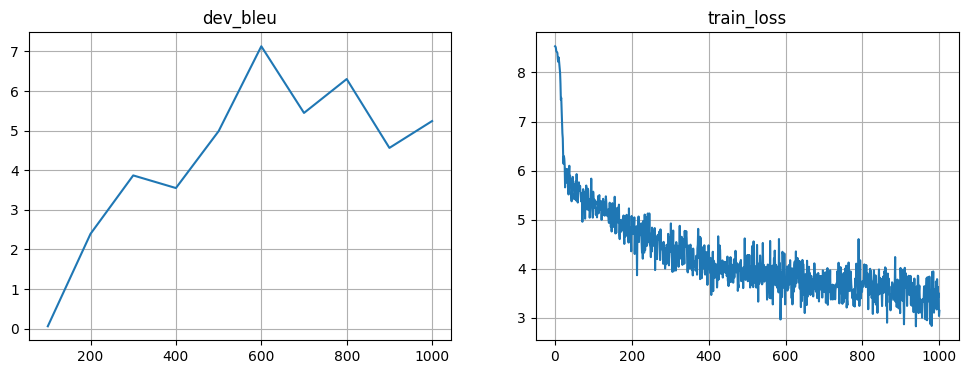

Mean loss=3.452


100%|██████████| 1000/1000 [09:37<00:00,  1.73it/s]


Значение BLUE: 5.241731711199322


In [13]:
modelwithBidirectionalEncoder = ModelwithBidirectionalEncoder(inp_voc, out_voc).to(device) 
print("Значение BLUE: " + str(model_training(modelwithBidirectionalEncoder)))

In [14]:
for inp_line, trans_line in zip(test_inp[::500], modelwithBidirectionalEncoder.translate_lines(test_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в в@@ а@@ н@@ н@@ о@@ й к@@ о@@ м@@ н@@ а@@ т@@ е с в@@ а@@ н@@ н@@ о@@ й п@@ р@@ е@@ д@@ о@@ с@@ т@@ а@@ в@@ л@@ я@@ е@@ т@@ с@@ я ф@@ е@@ н .
the private bathrooms come with a shower .

н@@ а т@@ е@@ р@@ р@@ и@@ т@@ о@@ р@@ и@@ и м@@ о@@ ж@@ н@@ о с@@ ы@@ г@@ р@@ а@@ т@@ ь в д@@ а@@ р@@ т@@ с и с@@ к@@ в@@ о@@ ш .
the property offers a restaurant and a restaurant .

а@@ п@@ а@@ р@@ т@@ а@@ м@@ е@@ н@@ т@@ ы р@@ а@@ с@@ п@@ о@@ л@@ а@@ г@@ а@@ ю@@ т г@@ о@@ с@@ т@@ и@@ н@@ о@@ й з@@ о@@ н@@ о@@ й .
the apartment features a tv , a private bathroom with a shower .

г@@ о@@ с@@ т@@ и м@@ о@@ г@@ у@@ т с@@ а@@ м@@ о@@ с@@ т@@ о@@ я@@ т@@ е@@ л@@ ь@@ н@@ о п@@ р@@ и@@ г@@ о@@ т@@ о@@ в@@ и@@ т@@ ь б@@ л@@ ю@@ д@@ а н@@ а п@@ о@@ л@@ н@@ о@@ с@@ т@@ ь@@ ю у@@ к@@ о@@ м@@ п@@ л@@ е@@ к@@ т@@ о@@ в@@ а@@ н@@ н@@ о@@ й к@@ у@@ х@@ н@@ е .
guests can enjoy a shared lounge at the property .

к у@@ с@@ л@@ у@@ г@@ а@@ м г@@ о@@ с@@ т@@ е@@ й 2 с@@ п@@ а@@ л@@ ь@@ н@@ и и 1 в@@ а@@ н@@ н@@ а@@ я к

По значению BLUE видно, что, по сравнению с тем же вычислением для обычного энкодера для 10 тысяч шагов цикла(5.34), теперь оно стало больше (8.12). это значит, что использования двунаправленного энкодера лучше, чем обычного

## 2.2 Попробовать различные attention (additive, dot-product, multi-head)


Additive attention использует обучаемую функцию для вычисления весов внимания. В этом подходе скрытые состояния декодера и энкодера комбинируются через нелинейную функцию, обычно через один или несколько слоёв нейронной сети.

Dot-product attention является более простым и быстрым вариантом, используя точечное произведение входов для вычисления весов внимания. Это основа scaled dot-product attention, используемого в Transformer моделях.

Multi-head attention позволяет модели одновременно учиться на различных представлениях входных данных, применяя dot-product attention параллельно в нескольких "головах". 

### additive attention

В задаче машинного перевода аддитивное внимание может помочь определить, какие слова в исходном предложении наиболее важны для понимания смысла текущего переводимого слова в целевом предложении. Это позволяет модели лучше справляться с переводом, учитывая контекст и значимость различных частей исходного текста.

In [15]:
class AdditiveAttention(nn.Module):
    def __init__(self, enc_hid_size, dec_hid_size, attn_size):
        super(AdditiveAttention, self).__init__()
        self.enc_hid_size = enc_hid_size
        self.dec_hid_size = dec_hid_size
        self.attn_size = attn_size
        
        # Веса для кодировщика и декодера
        self.enc_proj = nn.Linear(enc_hid_size, attn_size)
        self.dec_proj = nn.Linear(dec_hid_size, attn_size)
        
        # Вектор v, используемый для вычисления внимания
        self.v = nn.Parameter(torch.rand(attn_size))
        
    def forward(self, enc, dec, inp_mask):
        """
        Вычисляет внимание, используя метод добавочного внимания.
        :param enc: активации кодировщика (значения и ключи), форма: [batch_size, seq_len, hid_size]
        :param dec: состояние декодера (запрос), форма: [batch_size, hid_size]
        :param inp_mask: маска для активации кодировщика, форма: [batch_size, seq_len]
        :returns: выход внимания и веса внимания
        """
        # Преобразуем входы
        dec = self.dec_proj(dec).unsqueeze(1)  # [batch_size, 1, attn_size]
        enc = self.enc_proj(enc)  # [batch_size, seq_len, attn_size]
        
        # Суммируем трансформированные входы и применяем тангенс гиперболический
        sum_enc_dec = torch.tanh(enc + dec)  # [batch_size, seq_len, attn_size]
        
        # Вычисляем внимание с использованием параметра v
        v = self.v.repeat(enc.shape[0], 1, 1)  # Дублируем v для каждого элемента в пакете
        attention_scores = torch.bmm(sum_enc_dec, v.transpose(1, 2)).squeeze(2)  # [batch_size, seq_len]
        
        # Применяем маску и softmax
        attention_scores = attention_scores.masked_fill(inp_mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = attention_weights.unsqueeze(2)  # [batch_size, seq_len, 1]
        
        # Вычисляем выход внимания
        attention_output = torch.sum(enc * attention_weights, dim=1)
        return attention_output, attention_weights

In [16]:
class AttentiveModelWithAdditiveAttention(ModelwithBidirectionalEncoder):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AdditiveAttention(hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        """
        Принимает входные последовательности, вычисляет начальное состояние
        :param inp: матрица входных токенов [пакет, время]
        :return: список начальных тензоров состояния декодера
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


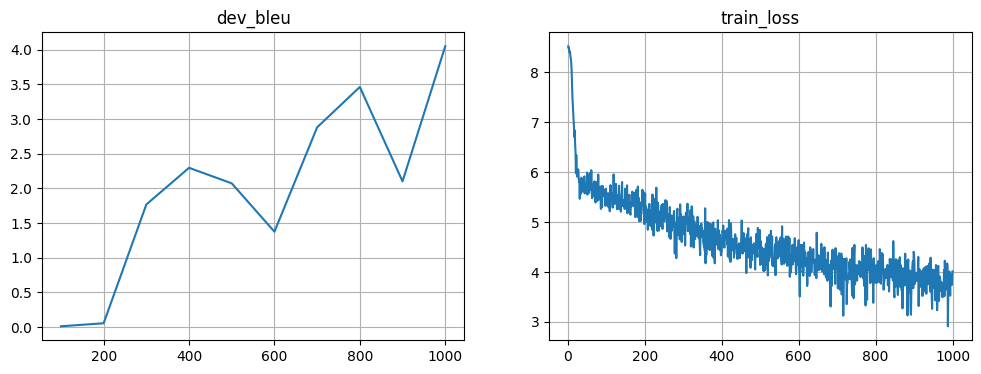

Mean loss=3.854


100%|██████████| 1000/1000 [27:15<00:00,  1.64s/it]


Значение BLUE: 4.050363348633004


In [17]:
modelWithAdditiveAttention = AttentiveModelWithAdditiveAttention(inp_voc, out_voc).to(device) 
print("Значение BLUE: " + str(model_training(modelWithAdditiveAttention)))

### dot-product attention

В машинном переводе dot-product attention позволяет модели сфокусироваться на правильных словах исходного предложения при переводе каждого слова целевого языка. Например, при переводе с английского на русский, этот механизм помогает точно соотнести слова, обеспечивая более точный и естественный перевод.

In [18]:
class DotProductAttention(nn.Module):
    def __init__(self):
        super(DotProductAttention, self).__init__()

    def forward(self, enc, dec, inp_mask):
        """
          Вычисляет внимание, используя метод скалярного произведения.
          :param enc: активации кодировщика (значения и ключи), форма: [batch_size, seq_len, hid_size]
          :param dec: состояние декодера (запрос), форма: [batch_size, hid_size]
          :param inp_mask: маска для активации кодировщика, форма: [batch_size, seq_len]
          :returns: выход внимания и веса внимания
        """

        dec = dec.unsqueeze(2)
        attention_scores = torch.bmm(enc, dec)
        attention_scores = attention_scores.squeeze(2)
        attention_scores = attention_scores.masked_fill(inp_mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = attention_weights.unsqueeze(2)
        attention_output = torch.sum(enc * attention_weights, dim=1)
        return attention_output, attention_weights

In [19]:
class AttentiveModelWithDotProductAttention(ModelwithBidirectionalEncoder):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        # self.attention = DotProductAttention(hid_size, hid_size, attn_size)
        self.attention = DotProductAttention()


    def encode(self, inp, **flags):
        """
        Принимает входные последовательности, вычисляет начальное состояние
        :param inp: матрица входных токенов [пакет, время]
        :return: список начальных тензоров состояния декодера
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)


        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


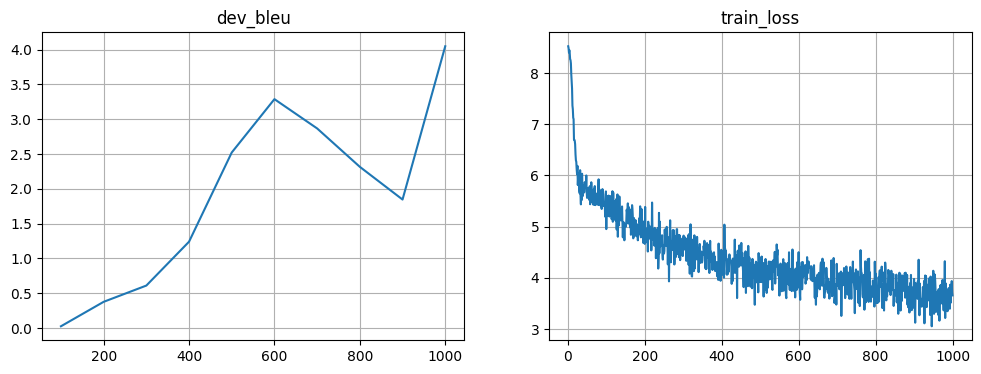

Mean loss=3.668


100%|██████████| 1000/1000 [16:52<00:00,  1.01s/it]


Значение BLUE: 4.0465262805898465


In [20]:
modelWithDotProductAttention = AttentiveModelWithDotProductAttention(inp_voc, out_voc).to(device) 
print("Значение BLUE: " + str(model_training(modelWithDotProductAttention)))

### multi-head attention

В контексте машинного перевода multi-head attention позволяет модели одновременно учитывать различные аспекты исходного текста при его переводе. Это может включать лексические детали (например, синонимы и антонимы), контекстуальные связи между словами и даже стилистические особенности текста. Результат — более точный и естественный перевод.

In [18]:
import math

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hid_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.hid_size = hid_size
        self.head_dim = hid_size // num_heads

        assert self.head_dim * num_heads == self.hid_size, "hid_size должен быть кратен num_heads"

        self.linear_keys = nn.Linear(hid_size, hid_size)
        self.linear_values = nn.Linear(hid_size, hid_size)
        self.linear_query = nn.Linear(hid_size, hid_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        batch_size = enc.size(0)
        seq_len = enc.size(1)

        # Преобразование входных данных кодера и декодера
        keys = self.linear_keys(enc).view(batch_size, seq_len, self.num_heads, self.head_dim)
        values = self.linear_values(enc).view(batch_size, seq_len, self.num_heads, self.head_dim)
        query = self.linear_query(dec).view(batch_size, 1, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)  # [batch_size, num_heads, seq_len, head_dim]
        # до транспонировать keys имел форму [batch_size, seq_len, num_heads, head_dim]
        query = query.transpose(1, 2)  # [batch_size, num_heads, 1, head_dim]
        # согласовывает размерность с keys
        # транспонирование позволяет модели правильно вычислять веса внимания для каждой "головы" независимо

        attention_scores = torch.matmul(query, keys.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attention_scores = attention_scores.squeeze(2)
        
        inp_mask = inp_mask.unsqueeze(1).repeat(1, self.num_heads, 1)  # Expand mask for all heads
        attention_scores = attention_scores.masked_fill(inp_mask == 0, float('-inf'))

        attention_weights = self.softmax(attention_scores)
        attention_output = torch.matmul(attention_weights.unsqueeze(2), values.transpose(1, 2)).squeeze(2)
        
        # Объединить выходные данные
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, self.hid_size)
        
        return attention_output, attention_weights


In [20]:
class AttentiveModelWithMultiHeadAttention(ModelwithBidirectionalEncoder):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128, num_heads=8):
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = MultiHeadAttention(hid_size, num_heads)


    def encode(self, inp, **flags):
        """
        Принимает входные последовательности, вычисляет начальное состояние
        :param inp: матрица входных токенов [пакет, время]
        :return: список начальных тензоров состояния декодера
        """
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)


        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


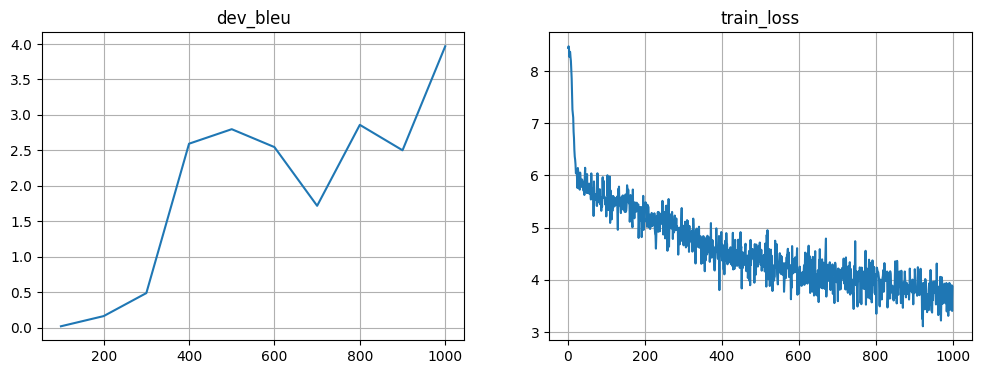

Mean loss=3.643


100%|██████████| 1000/1000 [29:39<00:00,  1.78s/it]


Значение BLUE: 3.9671708441273434


In [23]:
modelWithMultiHeadAttention = AttentiveModelWithMultiHeadAttention(inp_voc, out_voc).to(device) 
print("Значение BLUE: " + str(model_training(modelWithMultiHeadAttention)))

Для 10 тысяч проходов: проанализировав три различных attention, получается, что DotProductAttention (4.627) показало лучший результат, далее идет , и самаое худшее - MultiHeadAttention (3.738), AdditiveAttention (3.694). При этом, при проходе в 100 шагов цикла вместо 1000, AdditiveAttention показало лучший результат

## 2 word dropout, sheduling

### word dropout

Word dropout — это техника, используемая в обработке естественного языка, чтобы сделать модели более устойчивыми к различным входным данным и предотвратить их переобучение. Суть этой техники заключается в случайном заменении части слов в входном тексте на специальный токен, обычно называемый unk, который представляет неизвестное или отсутствующее слово.



In [24]:
class BasicModelWithDropout(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)

        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True, bidirectional=True)
        self.dec_start = nn.Linear(hid_size * 2, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def apply_word_dropout(self, input_tensor, dropout_rate=0.1, unk_idx=0):
        mask = torch.rand(input_tensor.shape, device=input_tensor.device) < dropout_rate
        input_tensor[mask] = unk_idx
        return input_tensor

    def encode(self, inp, **flags):
        # Применение Word Dropout перед эмбеддингом
        inp = self.apply_word_dropout(inp, dropout_rate=0.1, unk_idx=self.inp_voc.unk_ix)
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1)
        lengths = (lengths - 1).clamp(min=0)
        forward_states = enc_seq[torch.arange(batch_size), lengths, :self.hid_size]
        backward_states = enc_seq[:, 0, self.hid_size:]
        last_state = torch.cat([forward_states, backward_states], dim=-1)
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def forward(self, inp, out):
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)
        return [new_dec_state], output_logits

    def decode_inference(self, initial_state, max_len=100, **flags):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]
        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        return torch.stack(outputs, dim=1), all_states
    
    def translate_lines(self, inp_lines, **kwargs): # переводит входные строки 
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

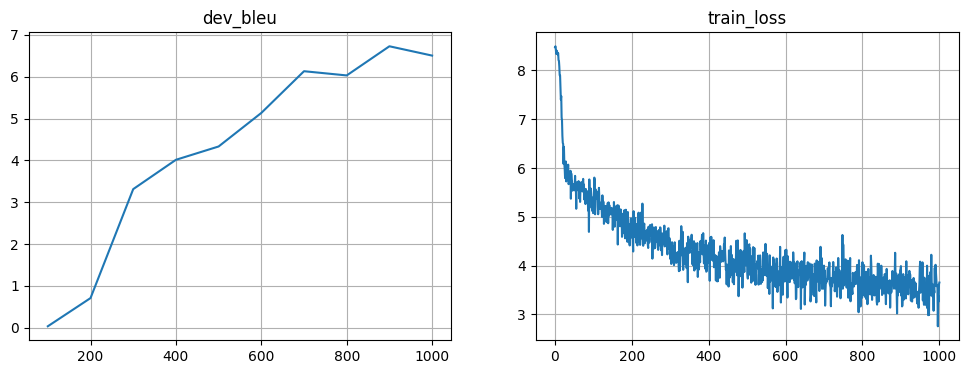

Mean loss=3.494


100%|██████████| 1000/1000 [11:36<00:00,  1.44it/s]


Значение BLUE: 6.553818554896187


In [25]:
modelWithDropout = BasicModelWithDropout(inp_voc, out_voc).to(device) 
print("Значение BLUE: " + str(model_training(modelWithDropout)))

### sheduling

Термин "scheduling" в контексте нейросетей обычно относится к постепенному изменению некоторого параметра в процессе обучения. "scheduled dropout" означает, что вероятность применения dropout к элементам входных данных изменяется по заданному расписанию.

In [26]:
import random

In [27]:
class BasicModelWithSheduling(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, max_dropout_rate=0.1, decay_steps=10000):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.global_step = 0
        self.max_dropout_rate = max_dropout_rate
        self.decay_steps = decay_steps

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)

        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True, bidirectional=True)
        self.dec_start = nn.Linear(hid_size * 2, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    '''
    dropout_rate постепенно уменьшается, стремится к нулю. Если он станет отрицательным, то станет 0
    после чего берется маска - тензор из 0 или 1, который применяем к входыным даным
    '''
    def apply_scheduled_dropout(self, input_tensor, unk_idx=0):
        dropout_rate = self.max_dropout_rate * (1 - self.global_step / self.decay_steps)
        dropout_rate = max(dropout_rate, 0)  # Ensure dropout rate doesn't go negative
        mask = torch.rand(input_tensor.shape, device=input_tensor.device) < dropout_rate
        input_tensor[mask] = unk_idx
        return input_tensor

    def encode(self, inp, **flags):
        # Применение Scheduled Dropout перед эмбеддингом
        inp = self.apply_scheduled_dropout(inp, unk_idx=self.inp_voc.unk_ix)
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1)
        lengths = (lengths - 1).clamp(min=0)
        forward_states = enc_seq[torch.arange(batch_size), lengths, :self.hid_size]
        backward_states = enc_seq[:, 0, self.hid_size:]
        last_state = torch.cat([forward_states, backward_states], dim=-1)
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def forward(self, inp, out):
        if self.training:
            self.global_step += 1
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)
        return [new_dec_state], output_logits
    
    def decode_inference(self, initial_state, max_len=100, **flags): # генерация входной последовательности в режиме ввода (inference)  
        """Генерация переводов из модели (жадная версия)"""
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len): 
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states
    
    def translate_lines(self, inp_lines, **kwargs): # переводит входные строки 
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


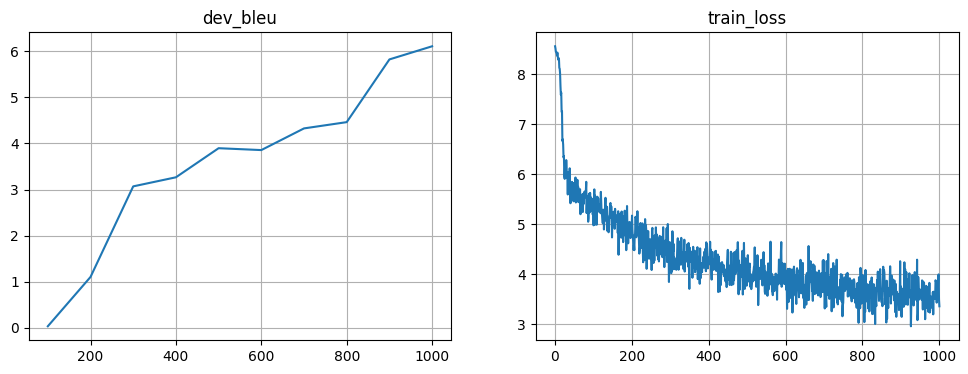

Mean loss=3.683


100%|██████████| 1000/1000 [11:54<00:00,  1.40it/s]


Значение BLUE: 6.1517987223978015


In [28]:
modelWithSheduling = BasicModelWithSheduling(inp_voc, out_voc).to(device) 
print("Значение BLUE: " + str(model_training(modelWithSheduling)))

Видно, что модель с использованием sheduling показала примерно такой же результат, как и без. Однако, возможно, при большем количество циклов обучения, результат был бы лучше 